# Model Simulations
This notebook contains code to conduct numerical simualtions for ...

In [1]:
using Pkg

Pkg.activate("../")

using DifferentialEquations, Plots
using Random, StatsBase, DelimitedFiles, Distributions
using SymPy, LinearAlgebra
using LaTeXStrings

const DifEq = DifferentialEquations

DifferentialEquations

In [2]:
include("./scripts/GLV.jl")

E_R_eco (generic function with 1 method)

# Analyitical Approximations
First we look to see what the expected effect of interactions is in the exponential phase. To do so we can take a taylor series of the $\log(C)$ around $t = 0$. This gives an expression for the biomass of species $i$ at some small value of $t$ as:

\begin{align}
    \log(C_i(t)) &\approx \log(C_i(0)) +
                    +  t \frac{d \log(C_i(0))}{d t}
                    + \frac{t^2}{2} \frac{d^2 \log(C_i(0))}{d t^2}
\end{align}



Using the correct definitions we use 'SymPy' to give the approximation in terms of the parameters in the system:

In [3]:
#define symbols
aii, ua   = symbols("a_ii,μ_a")
t,T,N = symbols("t,T,N")

#Time dependent variables
C,uC,sC,x = symbols("C,μ_C,σ_C,x")
C = SymPy.Function(C)(t)
uC = SymPy.Function(uC)(t)
sC = SymPy.Function(sC)(t)

#Temp dependent variables
r, ur, sr = symbols("r, μ_r, sigma_r")
r = SymPy.Function(r)(T)
ur = SymPy.Function(ur)(T)
sr = SymPy.Function(sr)(T) 

#non time/temp dependent variables for lambdify
r_ , ur_, sr_ = symbols("r, μ_r,sigma_r")
C0,uC0,sC0 = symbols("C_0,μ_{C_0},σ_{C_0}")
ua_ = symbols("u_a");

First we set up the approximations of biomass

In [4]:
#get series
C_app = C.series(t,0,3).removeO()
logC_app = log(C).series(t,0,3).removeO()

   ⎛⎛  2      ⎞│                     ⎞                               
   ⎜⎜ d       ⎟│                    2⎟                               
   ⎜⎜───(C(x))⎟│      ⎛d       ⎞│    ⎟     ⎛d       ⎞│               
   ⎜⎜  2      ⎟│      ⎜──(C(x))⎟│    ⎟   t⋅⎜──(C(x))⎟│               
 2 ⎜⎝dx       ⎠│x=0   ⎝dx      ⎠│x=0 ⎟     ⎝dx      ⎠│x=0            
t ⋅⎜─────────────── - ───────────────⎟ + ──────────────── + log(C(0))
   ⎜     2⋅C(0)              2       ⎟         C(0)                  
   ⎝                      2⋅C (0)    ⎠                               

Next we define the acutal equation for biomass growth $\frac{dC_i(t)}{dt}$ and the second time derivative $\frac{\delta^2 C_i(t)}{dt^2}$

In [5]:
#define dC system
dC = C*(r - (aii * C) + ua*uC)

#get second order derivative
dC2_1 = dC.diff(t)

⎛      d             d         ⎞                                       d      
⎜- aᵢᵢ⋅──(C(t)) + μₐ⋅──(μ_C(t))⎟⋅C(t) + (-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T))⋅──(C(t)
⎝      dt            dt        ⎠                                       dt     

 
)
 

From this we can see we need an equation for the derivative of the average biomass $\mu_C$ with respect to time. We approaximate this using a logistic growth equation with growth rate equal to the average growth rate across the community and a carrying capcity set by the solution of the mean-field approximation. We actualy use an exponential approximation of the logistic growth as we want to focus on the intial stages of communtiy assembly. 

In [6]:
#solve for K
uK = solve(solve(dC.args[1],C)[1].subs(r,ur) - uC, uC)[1]
duK = uK.diff(T)

d        
──(μᵣ(T))
dT       
─────────
 aᵢᵢ - μₐ

In [8]:
#derivative
# K = symbols("K")
# K = Function(K)(T)
# duC = (uC * ur * (1 - (uC / K)))
duC = uC * (ur - aii * uC - ua * uC)

(-aᵢᵢ⋅μ_C(t) - μₐ⋅μ_C(t) + μᵣ(T))⋅μ_C(t)

Next we substitue these expressions into the second derivative

In [9]:
#now substitute these terms to get dC2
dC2 = dC2_1.subs(C.diff(t),dC).subs(uC.diff(t),duC)

                                                                              
(-aᵢᵢ⋅(-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T))⋅C(t) + μₐ⋅(-aᵢᵢ⋅μ_C(t) - μₐ⋅μ_C(t) + μᵣ(T

                                                2     
))⋅μ_C(t))⋅C(t) + (-aᵢᵢ⋅C(t) + μₐ⋅μ_C(t) + r(T)) ⋅C(t)

And finally substitute these into the main approximation equations above

In [10]:
#params to sub
dC_sub = logC_app.args[1].args[2].args[2].args[3].args[1]
dC2_sub = logC_app.args[1].args[2].args[1].args[3]

#sub into the approximation
log_C_sol = logC_app.subs(dC_sub,dC.subs(t,0)).subs(dC2_sub,dC2.subs(t,0))

   ⎛                                                                          
 2 ⎜(-aᵢᵢ⋅(-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T))⋅C(0) + μₐ⋅(-aᵢᵢ⋅μ_C(0) - μₐ⋅μ_C(0) + 
t ⋅⎜──────────────────────────────────────────────────────────────────────────
   ⎝                                                               2⋅C(0)     

                                                    2                         
μᵣ(T))⋅μ_C(0))⋅C(0) + (-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T)) ⋅C(0)   (-aᵢᵢ⋅C(0) + μₐ⋅μ
────────────────────────────────────────────────────────── - ─────────────────
                                                                            2 

             2⎞                                               
_C(0) + r(T)) ⎟                                               
──────────────⎟ + t⋅(-aᵢᵢ⋅C(0) + μₐ⋅μ_C(0) + r(T)) + log(C(0))
              ⎠                                               

we use lambdify to get let us use this expression as a function 

In [12]:
#lambdify
#sub dependent vars
into = [r,ur,ua,C.subs(t,0),uC.subs(t,0),sC.subs(t,0)]
outo = [r_,ur_,ua_,C0,uC0,sC0]

final_log_C_sol = subs(log_C_sol,zip(into,outo)...) 

#lambdify parameter order -> (C0 aii r t ua ur uC0)
C_log_func = lambdify(final_log_C_sol)

#101 (generic function with 1 method)

And also calculate the $E_C$ value by taking the derivative of log biomass with respect to temperature

In [14]:
#Temperature dependence
x,y = symbols("x,y")

into = [r,ur,ua,C.subs(t,0),uC.subs(t,0),sC.subs(t,0)]
outo = [r_,ur_,ua_,C0,uC0,sC0]

E_C = log_C_sol.diff(T).expand().collect(ua)
E_C_final = subs(E_C,zip(into,outo)...)

          2 d        2            d               
  C₀⋅aᵢᵢ⋅t ⋅──(r)   t ⋅uₐ⋅μ_{C_0}⋅──(μᵣ)          
            dT                    dT         d    
- ─────────────── + ──────────────────── + t⋅──(r)
         2                   2               dT   

Which we can see is a funciton of the average interaction strength in the system $\mu_a$. Note $\mu_a$ only occurs as a product of the $t^2$ term showing that in the early stages of community assembly (when $t > t^2$) we expect there to be little effect of interacitons, but as $t$ grows, its effect will increase. We also lambdify this expression. 

In [15]:
#lambdify
dr_sub = E_C_final.args[1].args[2]
dur_sub = E_C_final.args[2].args[5]

E_C_final_2 = E_C_final.subs(dr_sub, x).subs(dur_sub, y)

# lambdify parameter order -> (C0 N aii t ua dr dur uc)
E_func = lambdify(E_C_final_2)

#101 (generic function with 1 method)

#### Testing the Approximation

Next we test this approximation of biomass dynamics to see how well it works. First we simualte communities across different levels of interaction strength

In [16]:
Random.seed!(42)

#Number of species
Nsp = 50 

#Interactions
ua_vec = [-10,0,10]
a = [ x/Nsp .+ randn(Nsp,Nsp)./Nsp for x = ua_vec]
[a[i][j,j] = -10 for i = eachindex(a), j = 1:Nsp]

#growth rate
R = fill(1.0,Nsp) .+ randn(Nsp)./10
r = fill(1.0,Nsp) .+ randn(Nsp)./10

#params object
p = params.(Ref(r),Ref(R),a,Nsp)


C0 = fill(0.01, Nsp)
tspan = (0.0,4.0)
tsave = tspan[1]:0.01:tspan[2]

prob = ODEProblem.(dC!, Ref(C0), Ref(tspan), p)
sols = [DifEq.solve(prob[i] , AutoTsit5(Rosenbrock23()), saveat = tsave) for i = eachindex(prob)];

Then we check how good the average biomass approximations are:

In [17]:
#logistic approximation of mean biomass
function logistic_approx(r,t,K,C0)
    (C0 * K) / (C0  + (K - C0)*exp(-r*t))
end

μ_r_vec = map(x -> mean(x.r), p)
μ_K_vec = uC_equi.(p);


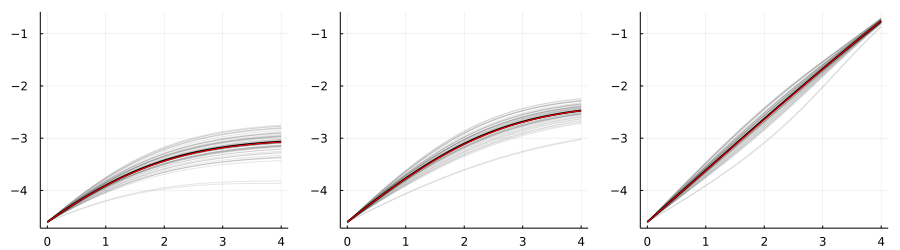

In [18]:
plots = [plot(tsave, log.(sols[i])', legend = false, c = "black", alpha = 0.1) for i = eachindex(sols)]
[plot!(plots[i],tsave,log.(mean(sols[i][:,:],dims=1)[:]), c = "black", lw = 2) for i = eachindex(sols)]

[plot!(plots[i],tsave,log.(logistic_approx.(μ_r_vec[i],tsave,μ_K_vec[i],mean(C0))), c = "red") for i = eachindex(sols)]

plot(plots..., layout = (1,length(ua_vec)), link = :y, size = (900,250))


As we can see the logistic approximation (red) follows the observed average (thick black line) very closely across the whole timeseries. The exponential approximation (blue) over estimates biomass as $t$ increases but is a reasonalble approximation when $t$ is small. It is also worth noting that the quantitative behaviour of the exponential approximation is the same as the observed, increasing in biomass as interactions become more positive. 

Next we test the total approximation derived above to see how it performs in predicting biomass in the initial stages of growth. 

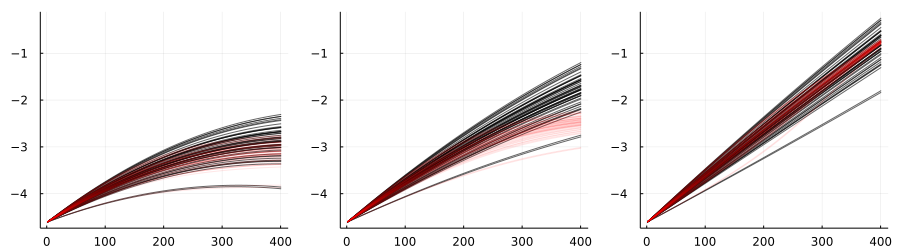

In [19]:
#test prediction on previous simulation

#get params
uC0 = mean(C0)
ur = mean(r)
aii = abs(a[1][1,1])

sp_ind = 1:Nsp
t_ind = 1:length(tsave)
pred = Array{Float64,3}(undef,length(t_ind),length(sp_ind),length(ua_vec))

for int = eachindex(ua_vec)
    ua_p = mean(a[int])
    for sp = sp_ind
        #(C0 aii r t ua ur uC0)
        pred[:,sp,int] .= C_log_func.(C0[sp], aii, r[sp], tsave[t_ind], ua_vec[int], ur, uC0)
    end
end

real = similar(pred)
for int = eachindex(ua_vec)
    real[:,:,int] = log.(sols[int][:,:]')
end


p = [plot(pred[:,:,i], legend = false, c = "black", alpha = 0.6) for i = eachindex(ua_vec)]
[plot!(p[i],real[:,:,i], legend = false, c = "red", alpha = 0.1) for i = eachindex(ua_vec)]
plot(p..., layout = (1,length(ua_vec)), size = (900,250), link = :y)

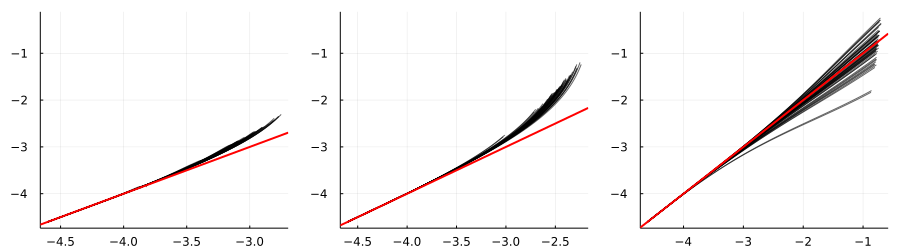

In [20]:
p = [plot(real[:,:,i],pred[:,:,i], legend = false, c = "black", alpha = 0.6) for i = eachindex(ua_vec)]
[Plots.abline!(p[i],1,0, color = "red",lw = 2) for  i = eachindex(ua_vec)]
plot(p..., layout = (1,length(ua_vec)), size = (900,250), link = :y)

These plots show the overlay of the predicted (red) and real (black) biomass over time and the predicted vs observed biomass (black) with a 1:1 line (red). We can see that there is a good corespondence between the approximation and the actual biomasses. Next we plot the prediced total biomass across levels of interactions:

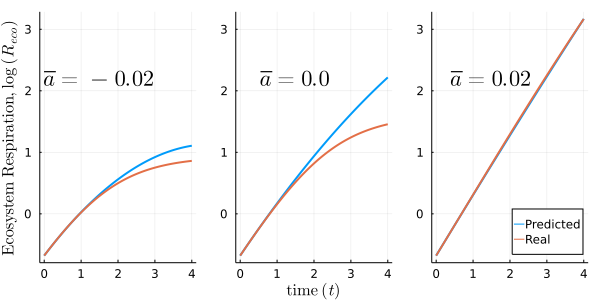

In [23]:
pred_R = mapslices(x -> sum(exp.(x) .* R), pred, dims = 2)[:,1,:]
real_R = mapslices(x -> sum(exp.(x) .* R), real, dims = 2)[:,1,:]

p = [plot(tsave, log.(pred_R[:,i]),legend = false, label = "Predicted", lw = 2, margin = 1Plots.mm) for  i = 1:length(ua_vec)]
[plot!(p[i],tsave, log.(real_R[:,i]), label = "Real", lw = 2) for  i = 1:length(ua_vec)]

annotate!(p[1],1.5,2.2,text(L"\overline{a} = -0.02", 15))
annotate!(p[2],1.5,2.2,text(L"\overline{a} = 0.0", 15))
annotate!(p[3],1.5,2.2,text(L"\overline{a} = 0.02", 15))

xlabel!(p[2],L"\mathrm{time} \ (t)")
ylabel!(p[1],L"\mathrm{Ecosystem \ Respiration}, \log \ (R_{eco})")

plot!(p[3],legend = :bottomright)

p_final = plot(p..., layout = (1,3), link = :y, size = (600,300))

savefig(p_final,"../plots/FigureSI_3_approx_time.pdf")

p_final

#### Temperature

Next we look at how the analytical approximation predicts respiration will change over temperature. 

first we look at the quality of the apporoximation across a temperature gradient

In [33]:
const k =  8.617e-5
kT(Temp) = 1 / (k * (Temp+273.15))

function boltz(B0,E,ΔT)
    B0 * exp(-E * ΔT )
end

function dboltz(B0,E,ΔT)
    -E * B0 * exp(-E * ΔT )
end


TtoΔT(T,Tref) = (kT(T) - kT(Tref))

TtoΔT (generic function with 1 method)

In [38]:
# set up temperature range
N_Temp = 24
T_vec = range(5,25,length=N_Temp)
ΔT_vec = TtoΔT.(T_vec,15)

#set up T-dependent variables
Er,ER = abs.(0.6 .+ randn(Nsp)/10) , abs.(0.6 .+ randn(Nsp)/10)
r_Temp = [boltz.(r,Er,T) for T = ΔT_vec]
R_Temp = [boltz.(R,ER,T) for T = ΔT_vec]

dr = dboltz.(r,Er,0.0)
dur = mean(dr)

# #set up results array
real = Array{Any,2}(undef, N_Temp, length(ua_vec))
pred = similar(real)
#respiration
real_R = similar(real)
pred_R = similar(real)
#E
real_E = similar(real)
pred_E = similar(real)
pred_E_eco = zeros(N_Temp, length(ua_vec))


for int = eachindex(ua_vec)
    for T = eachindex(T_vec)
        #real simualtions
        p_temp = params(r_Temp[T],R_Temp[T],a[int],Nsp)
        prob = ODEProblem(dC!, C0, tspan, p_temp)
        sol = DifEq.solve(prob , AutoTsit5(Rosenbrock23()), saveat = tsave)        
        real[T,int] = sol[end]
        
        #predictions
        
        pred[T,int] = exp.(C_log_func.(C0, aii, r_Temp[T] ,tsave[end], ua_vec[int], mean(r_Temp[T]), uC0))
        #respiration
        real_R[T,int] = sol[end] .* sol.prob.p.R
        pred_R[T,int] = pred[T,int] .* R_Temp[T]
        #ER - (C0 N aii t ua dr dur uc)
        pred_E[T,int] = E_func.(C0,aii,tsave[end],ua_vec[int],dr,dur,uC0)
        
        pred_E_eco[T,int] =  E_R_eco(R_Temp[T],  pred[T,int], ER , pred_E[T,int])
        
        
    end
end


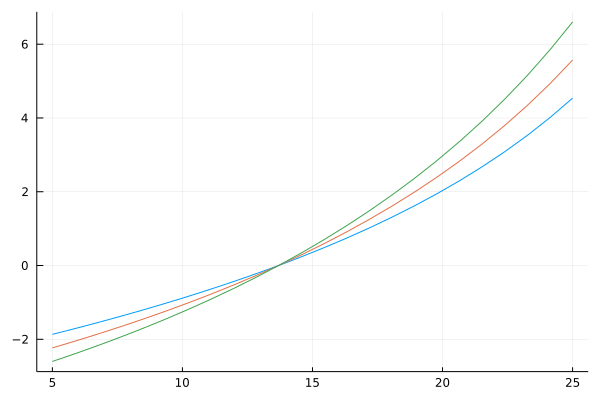

In [39]:
R_tot = sum.(pred_R)

#relative to the neutral case
R_rel = mapslices(x -> x ./ R_tot[11,:], (R_tot) , dims= 2)
plot(T_vec, log.(R_rel), legend = false)

In [40]:
writedlm("../data/theory/R.csv",R_rel,',')
writedlm("../data/theory/ER.csv",pred_E_eco[12,:],',')